## ISIC Lesion Diagnosis

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import clear_output, display, HTML
import pandas as pd

# This line is a work around for an error when viewing dataframes
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [3]:
path = Path('./data/isic_data')

In [4]:
path.ls()

[PosixPath('data/isic_data/submissions'),
 PosixPath('data/isic_data/train'),
 PosixPath('data/isic_data/models'),
 PosixPath('data/isic_data/test'),
 PosixPath('data/isic_data/validation'),
 PosixPath('data/isic_data/export.pkl'),
 PosixPath('data/isic_data/.ipynb_checkpoints')]

In [5]:
fnames = get_image_files(path/'train/Training_Input')
fnames[:3]

[PosixPath('data/isic_data/train/Training_Input/ISIC_0029576.jpg'),
 PosixPath('data/isic_data/train/Training_Input/ISIC_0027611.jpg'),
 PosixPath('data/isic_data/train/Training_Input/ISIC_0026868.jpg')]

In [6]:
# img_f = fnames[0]
# img = open_image(img_f)
# img.show(figsize=(5,5))

In [7]:
lbl_names = pd.read_csv(path/'train/images_with_label_col.csv')
lbl_names.tail()

,image,label
10010,ISIC_0034316,MEL
10011,ISIC_0034317,MEL
10012,ISIC_0034318,BKL
10013,ISIC_0034319,NV
10014,ISIC_0034320,NV


## ResNet 50 + 64x64

In [16]:
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(), size=64, bs=256, suffix='.jpg', 
                                    folder='train/Training_Input', csv_labels='train/images_with_label_col.csv',
                              test=path/'validation').normalize(imagenet_stats)

In [17]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


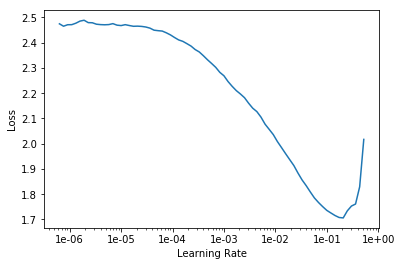

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(6, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,2.036185,1.278234,0.360959
2,1.606637,1.028794,0.294558
3,1.305476,0.790420,0.242636
4,1.082694,0.722752,0.237144
5,0.947900,0.693789,0.233150
6,0.867930,0.689855,0.234648


In [12]:
learn.save('stage-1-50')

In [13]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.769418,0.665539,0.229656
2,0.757896,0.648159,0.230155
3,0.734608,0.618442,0.224663
4,0.697901,0.600195,0.209186
5,0.669990,0.598198,0.210684


In [15]:
learn.save('stage-1-50')

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(8, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.648783,0.569793,0.204194
2,0.602745,0.579574,0.202197
3,0.559582,0.539168,0.188218
4,0.493429,0.495064,0.177234
5,0.422744,0.506872,0.174738
6,0.356529,0.458505,0.161258
7,0.292262,0.440410,0.159261
8,0.241597,0.439570,0.155267


In [18]:
learn.save('stage-2-50')

## ResNet 50 + 128x128 Size + Weight Decay (Best Model)

In [8]:
data = ImageDataBunch.from_csv(path/'train', ds_tfms=get_transforms(), size=128, bs=128, suffix='.jpg', 
                                    folder='Training_Input', csv_labels='images_with_label_col.csv', test=path/'validation').normalize(imagenet_stats)

In [9]:
def getLearner():
    return create_cnn(data, models.resnet50, pretrained=True, metrics=error_rate,
                      callback_fns=ShowGraph)

learner = getLearner()

In [12]:
# Code below is to find best weight decay rate

lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


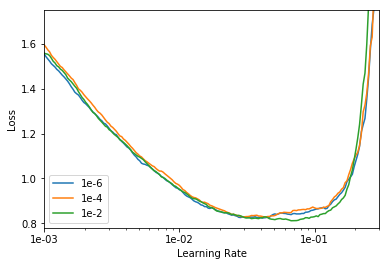

In [16]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.8
max_y = 1.75
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [11]:
max_lr = slice(1e-3,1e-2)
wd = 1e-4

epoch,train_loss,valid_loss,error_rate
1,1.284966,0.781403,0.245132
2,0.823752,0.585707,0.211682
3,0.657874,0.536546,0.193210
4,0.575309,0.522251,0.187718
5,0.494479,0.484591,0.174738
6,0.443249,0.455064,0.173739
7,0.389954,0.436051,0.156765
8,0.357697,0.433079,0.153769


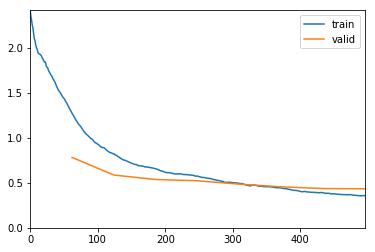

In [18]:
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

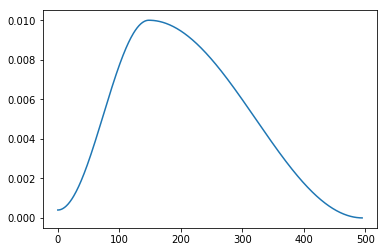

In [19]:
learner.recorder.plot_lr()

In [20]:
learner.save('Resnet50_wd_128_fit1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


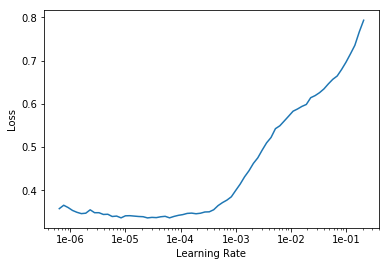

In [21]:
# load the baseline model
learner.load('Resnet50_wd_128_fit1')

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

epoch,train_loss,valid_loss,error_rate
1,0.350151,0.434562,0.159261
2,0.333922,0.425095,0.152272
3,0.327997,0.499763,0.169246
4,0.313957,0.470736,0.153270
5,0.266342,0.435352,0.139291
6,0.213356,0.440215,0.145282
7,0.160369,0.450259,0.139790
8,0.130319,0.407078,0.126810
9,0.091675,0.402228,0.118822
10,0.065781,0.391210,0.113330


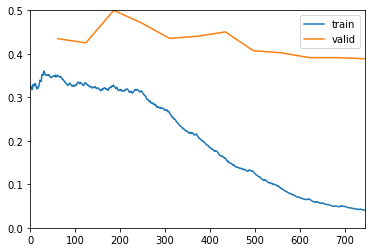

In [22]:
# Entered unintended learning rates here
learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))

In [23]:
learner.save('resnet50_128_wd')

In [16]:
learner.load('resnet50_128_wd');

epoch,train_loss,valid_loss,error_rate
1,0.125651,0.088055,0.022966
2,0.113189,0.082917,0.023465
3,0.122717,0.087085,0.022466
4,0.111288,0.083488,0.021967
5,0.115660,0.084590,0.021967
6,0.114922,0.083777,0.022466
7,0.112471,0.083973,0.022966
8,0.108191,0.087297,0.021967


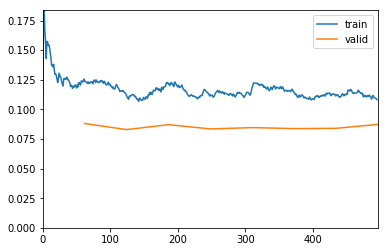

In [ ]:
# Fixed learning rate here which proved to have the lowest error rate and best balance between train and val losses
learner.fit_one_cycle(cyc_len=8, max_lr=slice(7e-6,6e-5))

In [19]:
learner.save('resnet50_128_wd_fit3')

## ResNet50 + 128x128 Size

In [19]:
data = ImageDataBunch.from_csv(path/'train', ds_tfms=get_transforms(), size=128, bs=128, suffix='.jpg', 
                                    folder='Training_Input', csv_labels='images_with_label_col.csv', test=path/'validation').normalize(imagenet_stats)

In [20]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


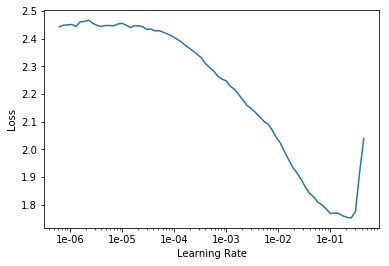

In [53]:
learn.lr_find()
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(6, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,1.809198,1.205534,0.340989
2,1.252242,0.770038,0.239141
3,0.883877,0.643282,0.223665
4,0.696814,0.605173,0.226660
5,0.632660,0.575373,0.208687
6,0.581391,0.571457,0.211183


In [55]:
learn.save('stage-2-50-128')

In [21]:
learn.load('stage-2-50-128');

In [22]:
learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.580953,0.482893,0.172741
2,0.576941,0.490544,0.172741
3,0.566723,0.512771,0.172242
4,0.539735,0.481835,0.165751
5,0.505656,0.486806,0.167748
6,0.474065,0.476225,0.169745
7,0.448346,0.466416,0.165252
8,0.425395,0.456948,0.159760
9,0.404361,0.455272,0.162257
10,0.399021,0.453987,0.157264


In [23]:
learn.save('stage-2-50-128')

In [24]:
learn.load('stage-2-50-128');

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(7, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.407730,0.476751,0.174239
2,0.477303,0.697608,0.208188
3,0.437782,0.559436,0.176236
4,0.354179,0.442169,0.150275
5,0.265105,0.427279,0.140789
6,0.176373,0.392908,0.121318
7,0.125180,0.391787,0.122816


In [27]:
learn.save('stage-2-50-128')

In [102]:
learn.load('stage-2-50-128');

In [29]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.156700,0.713738,0.178732
2,0.307955,0.436466,0.156765
3,0.228896,0.438936,0.141288
4,0.143688,0.392956,0.126810


In [103]:
learn.fit_one_cycle(6, max_lr=slice(9e-4,9e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.176906,0.168408,0.054418
2,0.213088,0.259649,0.074888
3,0.231135,0.201660,0.064903
4,0.194420,0.180855,0.060909
5,0.153301,0.154304,0.046930
6,0.121674,0.143207,0.043934


In [104]:
learn.save('stage-2-50-128')

In [53]:
learn.load('stage-2-50-128');

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(9e-4,9e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.128006,0.081017,0.027459
2,0.144606,0.138120,0.046430
3,0.184281,0.282512,0.080379
4,0.187740,0.186097,0.059910
5,0.168633,0.158432,0.052421
6,0.155585,0.145940,0.046430
7,0.126984,0.139242,0.043435
8,0.110773,0.147999,0.047429
9,0.096818,0.126712,0.040939
10,0.090250,0.127165,0.040939


In [56]:
learn.save('stage-2-50-128-final')

In [100]:
learn.load('stage-2-50-128-final');

In [101]:
learn.fit_one_cycle(10, max_lr=slice(8e-4,8e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.106818,0.050409,0.016975
2,0.114002,0.083674,0.028457
3,0.144922,0.120403,0.040939
4,0.148601,0.132185,0.042936
5,0.138795,0.132613,0.044433
6,0.132545,0.120581,0.040939
7,0.106266,0.107944,0.030454
8,0.096579,0.110361,0.038942
9,0.084801,0.101303,0.032951
10,0.075832,0.098132,0.030454


In [102]:
learn.save('stage-2-50-128-final1')

In [26]:
learn.load('stage-2-50-128-final1');

In [27]:
learn.fit_one_cycle(1, max_lr=slice(8e-4,8e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.129415,0.062335,0.021967


In [30]:
learn.save('stage-2-single-cycle')

## ResNet50 + 256x256

In [48]:
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(), size=256, bs=64, suffix='.jpg', 
                                    folder='/train/Training_Input', csv_labels='train/images_with_label_col.csv',
                              test=path/'test/test_input', valid_pct=0.05).normalize(imagenet_stats)

In [49]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


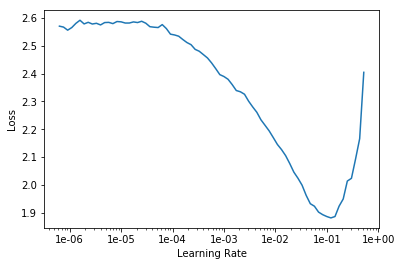

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(8, max_lr=slice(3e-4,3e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,1.343966,0.828851,0.242137
2,0.754798,0.574601,0.196206
3,0.552869,0.484074,0.181727
4,0.506984,0.446119,0.160260
5,0.431720,0.431685,0.154269
6,0.377039,0.393862,0.149276
7,0.321470,0.376095,0.137294
8,0.302467,0.371123,0.139790


In [15]:
learn.save('resnet50-256-fit1')

In [23]:
learn.load('resnet50-256-fit1');

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(8, max_lr=slice(3e-4,3e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.490089,0.689674,0.195207
2,0.566379,0.562124,0.195207
3,0.571012,0.625110,0.235647
4,0.508977,0.513134,0.182726
5,0.438985,0.430596,0.149775
6,0.346587,0.373347,0.123315
7,0.268132,0.287898,0.102346
8,0.184622,0.275463,0.097354


In [26]:
learn.save('resnet50-256-fit2')

In [ ]:
learn.load('resnet50-256-fit2')

In [27]:
learn.fit_one_cycle(8, max_lr=slice(3e-4,3e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.217282,0.358512,0.120819
2,0.392180,0.455219,0.160759
3,0.429894,0.514272,0.183724
4,0.380850,0.526384,0.185222
5,0.335152,0.402871,0.137793
6,0.250614,0.306713,0.102346
7,0.173309,0.301457,0.097853
8,0.127592,0.286585,0.096855


In [28]:
learn.save('resnet50-256-fit3')

In [29]:
learn.fit_one_cycle(4, max_lr=slice(4e-4,4e-3,2e-2))

epoch,train_loss,valid_loss,error_rate
1,0.291770,0.591605,0.174738
2,0.384303,0.364007,0.128807
3,0.286819,0.351241,0.129805
4,0.189855,0.298003,0.101348


In [50]:
learn.load('resnet50-256-fit3');

In [36]:
learn.fit_one_cycle(2, max_lr=slice(4e-4,4e-3,2e-2))

epoch,train_loss,valid_loss,error_rate
1,0.189379,0.131276,0.046000
2,0.166388,0.118770,0.044000


## ResNet50 + 299x299

In [77]:
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(), size=299, bs=16, suffix='.jpg', 
                                    folder='/train/Training_Input', csv_labels='train/images_with_label_col.csv',
                              test=path/'validation').normalize(imagenet_stats)

In [78]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


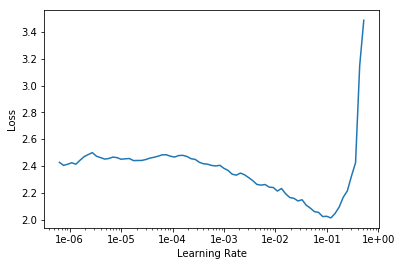

In [15]:
learn.lr_find()
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(6, max_lr=slice(3e-4,3e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.459210,0.431655,0.149775
2,0.436019,0.391739,0.145282
3,0.352452,0.374688,0.135297


In [81]:
learn.save('stage-3-50-299')

In [82]:
learn.fit_one_cycle(6, max_lr=slice(3e-4,3e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.323404,0.395552,0.133799
2,0.423969,0.416337,0.138792
3,0.407635,0.385865,0.138792
4,0.352503,0.340459,0.121318
5,0.297913,0.331404,0.115826
6,0.244297,0.328783,0.115327


In [83]:
learn.save('stage-3-50-299-1')

In [84]:
learn.unfreeze()

In [85]:
learn.fit_one_cycle(7, max_lr=slice(6e-4,3e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.844900,0.822174,0.277084
2,0.860560,1.091218,0.382926
3,0.815463,0.743959,0.265602
4,0.746166,1.146219,0.240639
5,0.670832,8.907621,0.234149
6,0.646178,0.573442,0.209685
7,0.565651,0.616055,0.189715


In [21]:
learn.save('stage-3-50-299')

In [92]:
learn.load('stage-3-50-299');

In [93]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.465793,0.361801,0.133799


## ResNet152 + 64x64

In [45]:
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(), size=64, bs=256, suffix='.jpg', 
                                    folder='train/Training_Input', csv_labels='train/images_with_label_col.csv',
                              test=path/'validation').normalize(imagenet_stats)

In [61]:
learn = create_cnn(data, models.resnet152, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


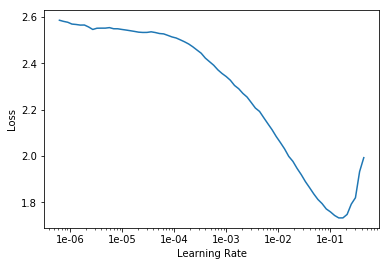

In [47]:
learn.lr_find()
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(6, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,1.511343,0.839434,0.254119
2,1.017718,0.619446,0.232651
3,0.810405,0.620528,0.222666
4,0.696868,0.550505,0.211682
5,0.611868,0.524009,0.204194
6,0.551432,0.517539,0.193709


In [63]:
learn.save('Resnet152-fit1')

In [64]:
learn.load('Resnet152-fit1');

In [65]:
learn.fit_one_cycle(6, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.495251,0.509349,0.191213
2,0.512559,0.597977,0.224663
3,0.522012,0.549247,0.198702
4,0.499093,0.493816,0.183724
5,0.458683,0.477600,0.177234
6,0.420122,0.474280,0.178233


In [66]:
learn.save('Resnet152-fit2')

In [69]:
learn.load('Resnet152-fit2');

In [70]:
learn.unfreeze()

In [71]:
learn.fit_one_cycle(6, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.418632,0.544293,0.186720
2,0.464246,0.785864,0.240140
3,0.454307,0.471206,0.176735
4,0.398444,0.456297,0.160260
5,0.324658,0.411942,0.145282
6,0.257798,0.415807,0.145781


In [72]:
learn.save('Resnet152-fit3')

In [73]:
learn.fit_one_cycle(6, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.182872,0.643283,0.210684
2,0.275813,0.571533,0.181727
3,0.320520,0.485738,0.164254
4,0.281399,0.449774,0.150774
5,0.221302,0.445593,0.137793
6,0.165077,0.445325,0.140789


In [74]:
learn.save('resnet152-fit4')

## ResNet152 + 128x128

In [79]:
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(), size=128, bs=128, suffix='.jpg', 
                                    folder='train/Training_Input', csv_labels='train/images_with_label_col.csv',
                              test=path/'validation').normalize(imagenet_stats)

In [80]:
learn = create_cnn(data, models.resnet152, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


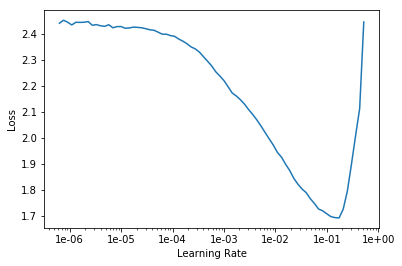

In [81]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.280107,0.454072,0.155766
2,0.354335,0.548299,0.189216
3,0.424622,0.545515,0.199700
4,0.402235,0.484620,0.163754
5,0.349788,0.438464,0.148278


In [85]:
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.221834,0.598987,0.176735
2,0.322792,0.573180,0.180230
3,0.291416,0.418656,0.139291
4,0.218260,0.415494,0.126311


In [86]:
learn.save('resnet152-128-fit1')

In [87]:
learn.unfreeze()

In [88]:
learn.fit_one_cycle(8, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.626957,2.559842,0.360459
2,0.645790,1.352245,0.354468
3,0.645691,1.021414,0.248627
4,0.616597,0.670482,0.242636
5,0.562352,0.650921,0.230654
6,0.506114,0.596045,0.207688
7,0.426355,0.438608,0.159261
8,0.367428,0.413713,0.145282


In [91]:
learn.save('resnet152-128-fit2')

In [92]:
learn.fit_one_cycle(8, max_lr=slice(1e-4,1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.316212,0.410605,0.152272
2,0.319722,0.422246,0.149775
3,0.318271,0.487843,0.164254
4,0.299114,0.446974,0.155267
5,0.279136,0.419590,0.140290
6,0.248747,0.417863,0.137793
7,0.221819,0.400616,0.137294
8,0.210026,0.404960,0.137793


In [95]:
learn.save('resnet152-128-fit3')

In [99]:
learn.load('resnet152-128-fit3');

In [ ]:
learn.fit(8, lr=1e-3)

## Confusion Matrix

In [22]:
interp = ClassificationInterpretation.from_learner(learner)

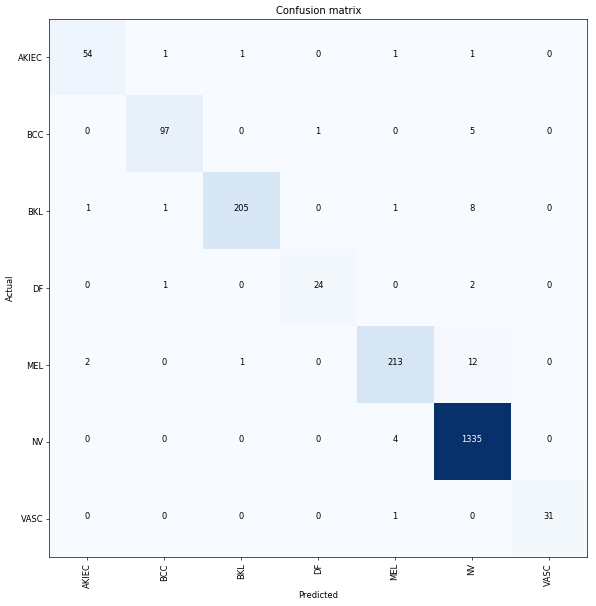

In [23]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

## Test/Submission

In [39]:
# Uncomment this if running on the test set instead of validation set

# data = ImageDataBunch.from_csv(path/'train', ds_tfms=get_transforms(), size=128, bs=128, suffix='.jpg', 
#                                     folder='Training_Input', csv_labels='images_with_label_col.csv', test=path/'test/test_input').normalize(imagenet_stats)

# learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [43]:
learner.load('resnet50_128_wd_fit3');

In [44]:
learner.export()

In [45]:
learn = load_learner(path/'train')

In [47]:
learn = load_learner(path/'train', test=ImageItemList.from_folder(path/'validation'))

In [48]:
TTA_preds, TTA_y = learn.TTA(ds_type=DatasetType.Test)
TTA_preds[:5]

tensor([[4.1998e-06, 1.4338e-05, 5.3751e-05, 1.3076e-06, 1.2511e-04, 9.9978e-01,
         2.0846e-05],
        [1.4673e-03, 1.8225e-04, 9.4674e-03, 1.9777e-04, 1.3675e-02, 9.7496e-01,
         4.8896e-05],
        [3.0726e-03, 7.7782e-05, 9.9906e-03, 1.0991e-04, 2.6240e-02, 9.6046e-01,
         4.9656e-05],
        [5.3577e-05, 9.6473e-03, 6.8514e-02, 1.6860e-04, 8.5506e-04, 8.9004e-01,
         3.0717e-02],
        [1.0457e-04, 4.2212e-05, 1.4082e-03, 5.2011e-05, 8.4157e-04, 9.9755e-01,
         6.2138e-06]])

In [114]:
TTA_preds.size()

torch.Size([193, 7])

In [115]:
np.argmax(TTA_preds[6])

tensor(2)

In [49]:
df = pd.DataFrame(TTA_preds)
df.columns = data.classes

In [50]:
from os import listdir
from os.path import isfile, join
val_names = [f for f in listdir('data/isic_data/validation') if isfile(join('data/isic_data/validation', f))]
# test_names = [f for f in listdir('data/isic_data/test') if isfile(join('data/isic_data/test', f))]

In [51]:
# Replace val_names with test_names if using the test set
df.insert(0, 'image', [i[:12] for i in val_names])

In [52]:
df.head()

,image,AKIEC,BCC,BKL,DF,MEL,NV,VASC
0,ISIC_0034401,tensor(4.1998e-06),tensor(1.4338e-05),tensor(5.3751e-05),tensor(1.3076e-06),tensor(0.0001),tensor(0.9998),tensor(2.0846e-05)
1,ISIC_0034514,tensor(0.0015),tensor(0.0002),tensor(0.0095),tensor(0.0002),tensor(0.0137),tensor(0.9750),tensor(4.8896e-05)
2,ISIC_0034378,tensor(0.0031),tensor(7.7782e-05),tensor(0.0100),tensor(0.0001),tensor(0.0262),tensor(0.9605),tensor(4.9656e-05)
3,ISIC_0034449,tensor(5.3577e-05),tensor(0.0096),tensor(0.0685),tensor(0.0002),tensor(0.0009),tensor(0.8900),tensor(0.0307)
4,ISIC_0034369,tensor(0.0001),tensor(4.2212e-05),tensor(0.0014),tensor(5.2011e-05),tensor(0.0008),tensor(0.9975),tensor(6.2138e-06)


In [53]:
SUBM = f'data/isic_data/submissions'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}ISIC_Test3_Submission.csv', index=False)

## Scoring Metric (Balanced Multiclass Accuracy)

In [5]:
from sklearn.metrics import confusion_matrix
def get_balanced_accuracy(probs,y,classes): # sz: image size, bs: batch size
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]
    cm = confusion_matrix(y, preds)
#     plot_confusion_matrix(cm, classes)
    return ((
    cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3]+cm[0][4]+cm[0][5]+cm[0][6]) + 
    cm[1][1]/(cm[1][0]+cm[1][1]+cm[1][2]+cm[1][3]+cm[1][4]+cm[1][5]+cm[1][6]) +
    cm[2][2]/(cm[2][0]+cm[2][1]+cm[2][2]+cm[2][3]+cm[2][4]+cm[2][5]+cm[2][6]) +
    cm[3][3]/(cm[3][0]+cm[3][1]+cm[3][2]+cm[3][3]+cm[3][4]+cm[3][5]+cm[3][6]) +
    cm[4][4]/(cm[4][0]+cm[4][1]+cm[4][2]+cm[4][3]+cm[4][4]+cm[4][5]+cm[4][6]) +
    cm[5][5]/(cm[5][0]+cm[5][1]+cm[5][2]+cm[5][3]+cm[5][4]+cm[5][5]+cm[5][6]) +
    cm[6][6]/(cm[6][0]+cm[6][1]+cm[6][2]+cm[6][3]+cm[6][4]+cm[6][5]+cm[6][6]) 
    )/7)

In [10]:
learner.load('resnet50_128_wd_fit3');

In [13]:
val_preds,val_y = learner.TTA(ds_type=DatasetType.Valid)

In [14]:
final_acc = get_balanced_accuracy(val_preds, val_y,data.classes)
final_acc

0.9393783233074787